<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[20:54:36] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


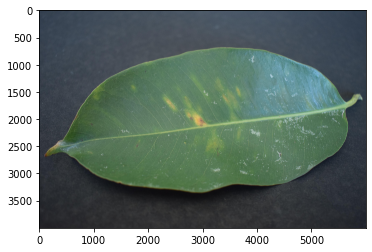

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

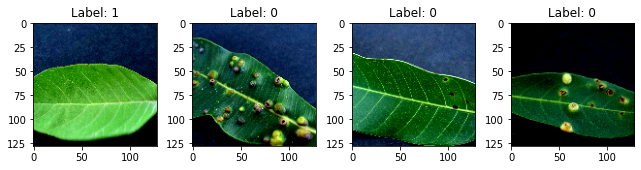

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[20:54:41] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[20:54:43] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2378058839621908 samples/sec                   batch loss = 1.0286041498184204 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.260087517760944 samples/sec                   batch loss = 0.27117398381233215 | accuracy = 0.6


Epoch[1] Batch[15] Speed: 1.2647915646266092 samples/sec                   batch loss = 0.5171814560890198 | accuracy = 0.6166666666666667


Epoch[1] Batch[20] Speed: 1.2605275649794083 samples/sec                   batch loss = 1.0018852949142456 | accuracy = 0.625


Epoch[1] Batch[25] Speed: 1.2342076131613375 samples/sec                   batch loss = 0.4074658155441284 | accuracy = 0.62


Epoch[1] Batch[30] Speed: 1.2624515459470913 samples/sec                   batch loss = 0.5556896924972534 | accuracy = 0.6333333333333333


Epoch[1] Batch[35] Speed: 1.2650318908043536 samples/sec                   batch loss = 0.7092952728271484 | accuracy = 0.6071428571428571


Epoch[1] Batch[40] Speed: 1.2639146723559798 samples/sec                   batch loss = 0.47211647033691406 | accuracy = 0.6125


Epoch[1] Batch[45] Speed: 1.262315809938933 samples/sec                   batch loss = 1.0102952718734741 | accuracy = 0.6166666666666667


Epoch[1] Batch[50] Speed: 1.264247830076187 samples/sec                   batch loss = 0.37229588627815247 | accuracy = 0.625


Epoch[1] Batch[55] Speed: 1.261301232325884 samples/sec                   batch loss = 0.6621975302696228 | accuracy = 0.6181818181818182


Epoch[1] Batch[60] Speed: 1.2634615055866238 samples/sec                   batch loss = 0.9019877314567566 | accuracy = 0.6208333333333333


Epoch[1] Batch[65] Speed: 1.2619255772105056 samples/sec                   batch loss = 0.5419696569442749 | accuracy = 0.6115384615384616


Epoch[1] Batch[70] Speed: 1.2652220229807876 samples/sec                   batch loss = 0.5120048522949219 | accuracy = 0.6178571428571429


Epoch[1] Batch[75] Speed: 1.2652258395653657 samples/sec                   batch loss = 1.0957484245300293 | accuracy = 0.6133333333333333


Epoch[1] Batch[80] Speed: 1.2665352361691293 samples/sec                   batch loss = 0.6512578725814819 | accuracy = 0.625


Epoch[1] Batch[85] Speed: 1.260182828939951 samples/sec                   batch loss = 0.9070769548416138 | accuracy = 0.6323529411764706


Epoch[1] Batch[90] Speed: 1.2671265885988172 samples/sec                   batch loss = 0.7932425141334534 | accuracy = 0.6305555555555555


Epoch[1] Batch[95] Speed: 1.2745771735640736 samples/sec                   batch loss = 0.5936949253082275 | accuracy = 0.6263157894736842


Epoch[1] Batch[100] Speed: 1.2657204728876614 samples/sec                   batch loss = 0.5319514870643616 | accuracy = 0.6325


Epoch[1] Batch[105] Speed: 1.2655910978124045 samples/sec                   batch loss = 0.8562870025634766 | accuracy = 0.6285714285714286


Epoch[1] Batch[110] Speed: 1.271296114295604 samples/sec                   batch loss = 0.8525915145874023 | accuracy = 0.6295454545454545


Epoch[1] Batch[115] Speed: 1.2666185201296665 samples/sec                   batch loss = 0.42659449577331543 | accuracy = 0.6282608695652174


Epoch[1] Batch[120] Speed: 1.2655179720171532 samples/sec                   batch loss = 0.6580637097358704 | accuracy = 0.6333333333333333


Epoch[1] Batch[125] Speed: 1.2646238672464298 samples/sec                   batch loss = 0.6924319267272949 | accuracy = 0.632


Epoch[1] Batch[130] Speed: 1.2658072788149655 samples/sec                   batch loss = 0.45512911677360535 | accuracy = 0.6307692307692307


Epoch[1] Batch[135] Speed: 1.2679154708710807 samples/sec                   batch loss = 0.15903030335903168 | accuracy = 0.6370370370370371


Epoch[1] Batch[140] Speed: 1.2636575428959778 samples/sec                   batch loss = 0.7613493204116821 | accuracy = 0.6375


Epoch[1] Batch[145] Speed: 1.2663930763452262 samples/sec                   batch loss = 0.6403871774673462 | accuracy = 0.6379310344827587


Epoch[1] Batch[150] Speed: 1.2668463400187808 samples/sec                   batch loss = 0.441897988319397 | accuracy = 0.6366666666666667


Epoch[1] Batch[155] Speed: 1.2617298870910307 samples/sec                   batch loss = 0.32831597328186035 | accuracy = 0.6403225806451613


Epoch[1] Batch[160] Speed: 1.264112945760405 samples/sec                   batch loss = 0.40603357553482056 | accuracy = 0.640625


Epoch[1] Batch[165] Speed: 1.2640838008130357 samples/sec                   batch loss = 2.025893211364746 | accuracy = 0.6393939393939394


Epoch[1] Batch[170] Speed: 1.2670933809440732 samples/sec                   batch loss = 0.48634976148605347 | accuracy = 0.6426470588235295


Epoch[1] Batch[175] Speed: 1.264749516933268 samples/sec                   batch loss = 0.4795945882797241 | accuracy = 0.6442857142857142


Epoch[1] Batch[180] Speed: 1.2670697442790577 samples/sec                   batch loss = 0.2827613353729248 | accuracy = 0.6486111111111111


Epoch[1] Batch[185] Speed: 1.266856480004132 samples/sec                   batch loss = 0.2923004627227783 | accuracy = 0.6513513513513514


Epoch[1] Batch[190] Speed: 1.2606236057954427 samples/sec                   batch loss = 0.5314831733703613 | accuracy = 0.6539473684210526


Epoch[1] Batch[195] Speed: 1.258106761548757 samples/sec                   batch loss = 0.7850251197814941 | accuracy = 0.6538461538461539


Epoch[1] Batch[200] Speed: 1.2619301332805812 samples/sec                   batch loss = 0.7448354959487915 | accuracy = 0.6525


Epoch[1] Batch[205] Speed: 1.2588132298464174 samples/sec                   batch loss = 0.9065170288085938 | accuracy = 0.65


Epoch[1] Batch[210] Speed: 1.2659181670688648 samples/sec                   batch loss = 0.4741532802581787 | accuracy = 0.6511904761904762


Epoch[1] Batch[215] Speed: 1.258934893411001 samples/sec                   batch loss = 0.5205269455909729 | accuracy = 0.6546511627906977


Epoch[1] Batch[220] Speed: 1.2654006638195707 samples/sec                   batch loss = 0.5635254979133606 | accuracy = 0.6568181818181819


Epoch[1] Batch[225] Speed: 1.2606200063687654 samples/sec                   batch loss = 0.8401194214820862 | accuracy = 0.6511111111111111


Epoch[1] Batch[230] Speed: 1.2660083437606446 samples/sec                   batch loss = 0.5702748894691467 | accuracy = 0.6554347826086957


Epoch[1] Batch[235] Speed: 1.261975600865507 samples/sec                   batch loss = 0.6378812193870544 | accuracy = 0.6553191489361702


Epoch[1] Batch[240] Speed: 1.2633368727193757 samples/sec                   batch loss = 0.42104122042655945 | accuracy = 0.6604166666666667


Epoch[1] Batch[245] Speed: 1.2616920277762695 samples/sec                   batch loss = 0.42452389001846313 | accuracy = 0.6612244897959184


Epoch[1] Batch[250] Speed: 1.264870900314574 samples/sec                   batch loss = 0.47683313488960266 | accuracy = 0.665


Epoch[1] Batch[255] Speed: 1.2671515672613398 samples/sec                   batch loss = 1.138066291809082 | accuracy = 0.6647058823529411


Epoch[1] Batch[260] Speed: 1.265304943464743 samples/sec                   batch loss = 0.46112552285194397 | accuracy = 0.6663461538461538


Epoch[1] Batch[265] Speed: 1.2627747131885438 samples/sec                   batch loss = 0.7348709106445312 | accuracy = 0.6679245283018868


Epoch[1] Batch[270] Speed: 1.2607096192626315 samples/sec                   batch loss = 0.6277567744255066 | accuracy = 0.6685185185185185


Epoch[1] Batch[275] Speed: 1.2641471404021634 samples/sec                   batch loss = 0.9870808124542236 | accuracy = 0.6690909090909091


Epoch[1] Batch[280] Speed: 1.2651602929234056 samples/sec                   batch loss = 0.27589860558509827 | accuracy = 0.6678571428571428


Epoch[1] Batch[285] Speed: 1.2682190086324259 samples/sec                   batch loss = 0.4087751805782318 | accuracy = 0.6684210526315789


Epoch[1] Batch[290] Speed: 1.2639847561347712 samples/sec                   batch loss = 1.1256623268127441 | accuracy = 0.6672413793103448


Epoch[1] Batch[295] Speed: 1.2603823002743852 samples/sec                   batch loss = 0.40007126331329346 | accuracy = 0.6686440677966101


Epoch[1] Batch[300] Speed: 1.2627809862270054 samples/sec                   batch loss = 0.6533346176147461 | accuracy = 0.6683333333333333


Epoch[1] Batch[305] Speed: 1.2641369484909064 samples/sec                   batch loss = 0.7181302309036255 | accuracy = 0.6680327868852459


Epoch[1] Batch[310] Speed: 1.2688722943406998 samples/sec                   batch loss = 0.275269091129303 | accuracy = 0.6717741935483871


Epoch[1] Batch[315] Speed: 1.2603836258764989 samples/sec                   batch loss = 0.4221622347831726 | accuracy = 0.6730158730158731


Epoch[1] Batch[320] Speed: 1.2671283112335818 samples/sec                   batch loss = 0.5492080450057983 | accuracy = 0.671875


Epoch[1] Batch[325] Speed: 1.2672411540122694 samples/sec                   batch loss = 0.5355491042137146 | accuracy = 0.6730769230769231


Epoch[1] Batch[330] Speed: 1.2651550456692695 samples/sec                   batch loss = 0.3876630663871765 | accuracy = 0.6704545454545454


Epoch[1] Batch[335] Speed: 1.2582156441505687 samples/sec                   batch loss = 0.9023685455322266 | accuracy = 0.667910447761194


Epoch[1] Batch[340] Speed: 1.260989623219468 samples/sec                   batch loss = 0.40726593136787415 | accuracy = 0.6705882352941176


Epoch[1] Batch[345] Speed: 1.2564818974796768 samples/sec                   batch loss = 0.4669055938720703 | accuracy = 0.6717391304347826


Epoch[1] Batch[350] Speed: 1.26108791466836 samples/sec                   batch loss = 0.5359198451042175 | accuracy = 0.6742857142857143


Epoch[1] Batch[355] Speed: 1.2660226738670386 samples/sec                   batch loss = 0.8336184024810791 | accuracy = 0.6746478873239437


Epoch[1] Batch[360] Speed: 1.2610254499575067 samples/sec                   batch loss = 0.8718733787536621 | accuracy = 0.6756944444444445


Epoch[1] Batch[365] Speed: 1.2658023126982625 samples/sec                   batch loss = 0.5702695846557617 | accuracy = 0.6773972602739726


Epoch[1] Batch[370] Speed: 1.2624249473689122 samples/sec                   batch loss = 0.5370245575904846 | accuracy = 0.677027027027027


Epoch[1] Batch[375] Speed: 1.274618134200967 samples/sec                   batch loss = 0.2775367796421051 | accuracy = 0.6806666666666666


Epoch[1] Batch[380] Speed: 1.2686609171717325 samples/sec                   batch loss = 0.7051651477813721 | accuracy = 0.6815789473684211


Epoch[1] Batch[385] Speed: 1.2561396525995363 samples/sec                   batch loss = 0.4668736159801483 | accuracy = 0.6792207792207792


Epoch[1] Batch[390] Speed: 1.25802412147901 samples/sec                   batch loss = 0.6051997542381287 | accuracy = 0.6801282051282052


Epoch[1] Batch[395] Speed: 1.2564109496036444 samples/sec                   batch loss = 0.5676654577255249 | accuracy = 0.6816455696202531


Epoch[1] Batch[400] Speed: 1.2552677620682824 samples/sec                   batch loss = 1.0573740005493164 | accuracy = 0.681875


Epoch[1] Batch[405] Speed: 1.2596786100210773 samples/sec                   batch loss = 0.2035067230463028 | accuracy = 0.682716049382716


Epoch[1] Batch[410] Speed: 1.2586511742358315 samples/sec                   batch loss = 0.6445154547691345 | accuracy = 0.6829268292682927


Epoch[1] Batch[415] Speed: 1.2615661310587687 samples/sec                   batch loss = 1.0495966672897339 | accuracy = 0.6819277108433734


Epoch[1] Batch[420] Speed: 1.2680482926917385 samples/sec                   batch loss = 0.5746230483055115 | accuracy = 0.6797619047619048


Epoch[1] Batch[425] Speed: 1.262445086189343 samples/sec                   batch loss = 0.49143385887145996 | accuracy = 0.6794117647058824


Epoch[1] Batch[430] Speed: 1.2615817837665984 samples/sec                   batch loss = 0.3355884253978729 | accuracy = 0.6813953488372093


Epoch[1] Batch[435] Speed: 1.2611838512812987 samples/sec                   batch loss = 0.185393288731575 | accuracy = 0.6839080459770115


Epoch[1] Batch[440] Speed: 1.2608611186535676 samples/sec                   batch loss = 0.3285869359970093 | accuracy = 0.6840909090909091


Epoch[1] Batch[445] Speed: 1.2594521314885028 samples/sec                   batch loss = 0.5416322350502014 | accuracy = 0.6848314606741573


Epoch[1] Batch[450] Speed: 1.2622037476217842 samples/sec                   batch loss = 0.3649974465370178 | accuracy = 0.6855555555555556


Epoch[1] Batch[455] Speed: 1.2587815898378611 samples/sec                   batch loss = 0.36995670199394226 | accuracy = 0.6868131868131868


Epoch[1] Batch[460] Speed: 1.2657705113746618 samples/sec                   batch loss = 0.23090264201164246 | accuracy = 0.6875


Epoch[1] Batch[465] Speed: 1.2689706667860716 samples/sec                   batch loss = 0.6153337359428406 | accuracy = 0.6860215053763441


Epoch[1] Batch[470] Speed: 1.26149982480439 samples/sec                   batch loss = 0.6520699262619019 | accuracy = 0.6845744680851064


Epoch[1] Batch[475] Speed: 1.2642860334777908 samples/sec                   batch loss = 0.8714377880096436 | accuracy = 0.6842105263157895


Epoch[1] Batch[480] Speed: 1.2674982119492333 samples/sec                   batch loss = 0.47001609206199646 | accuracy = 0.684375


Epoch[1] Batch[485] Speed: 1.2655815508843304 samples/sec                   batch loss = 0.36399173736572266 | accuracy = 0.684020618556701


Epoch[1] Batch[490] Speed: 1.2635372487145065 samples/sec                   batch loss = 0.3240059018135071 | accuracy = 0.6846938775510204


Epoch[1] Batch[495] Speed: 1.2608274805598942 samples/sec                   batch loss = 0.5940529704093933 | accuracy = 0.6858585858585858


Epoch[1] Batch[500] Speed: 1.266709370463288 samples/sec                   batch loss = 0.3406967222690582 | accuracy = 0.686


Epoch[1] Batch[505] Speed: 1.2662431117737054 samples/sec                   batch loss = 0.45027950406074524 | accuracy = 0.6861386138613862


Epoch[1] Batch[510] Speed: 1.2630401361840418 samples/sec                   batch loss = 0.29461318254470825 | accuracy = 0.6852941176470588


Epoch[1] Batch[515] Speed: 1.2610639327956361 samples/sec                   batch loss = 0.37111711502075195 | accuracy = 0.6854368932038835


Epoch[1] Batch[520] Speed: 1.2578910334149949 samples/sec                   batch loss = 0.1856386810541153 | accuracy = 0.6875


Epoch[1] Batch[525] Speed: 1.263133802371532 samples/sec                   batch loss = 0.6108479499816895 | accuracy = 0.6880952380952381


Epoch[1] Batch[530] Speed: 1.2637953764079852 samples/sec                   batch loss = 1.0855510234832764 | accuracy = 0.6882075471698114


Epoch[1] Batch[535] Speed: 1.2637673884417806 samples/sec                   batch loss = 0.30299675464630127 | accuracy = 0.6883177570093458


Epoch[1] Batch[540] Speed: 1.262950762115518 samples/sec                   batch loss = 0.7854782938957214 | accuracy = 0.6884259259259259


Epoch[1] Batch[545] Speed: 1.2604025633540024 samples/sec                   batch loss = 0.5254613161087036 | accuracy = 0.6871559633027523


Epoch[1] Batch[550] Speed: 1.2598135902377832 samples/sec                   batch loss = 0.293754905462265 | accuracy = 0.6872727272727273


Epoch[1] Batch[555] Speed: 1.262571253420533 samples/sec                   batch loss = 0.6631289124488831 | accuracy = 0.6869369369369369


Epoch[1] Batch[560] Speed: 1.2702760961829744 samples/sec                   batch loss = 0.5865851044654846 | accuracy = 0.6866071428571429


Epoch[1] Batch[565] Speed: 1.262724436086434 samples/sec                   batch loss = 0.8114662766456604 | accuracy = 0.6867256637168142


Epoch[1] Batch[570] Speed: 1.2626586732177265 samples/sec                   batch loss = 0.47795921564102173 | accuracy = 0.6877192982456141


Epoch[1] Batch[575] Speed: 1.2672222019124182 samples/sec                   batch loss = 0.5441197752952576 | accuracy = 0.6873913043478261


Epoch[1] Batch[580] Speed: 1.2643214761043906 samples/sec                   batch loss = 0.2260313779115677 | accuracy = 0.6879310344827586


Epoch[1] Batch[585] Speed: 1.2615816889005327 samples/sec                   batch loss = 0.7378839254379272 | accuracy = 0.688034188034188


Epoch[1] Batch[590] Speed: 1.2644092337388304 samples/sec                   batch loss = 0.8165468573570251 | accuracy = 0.688135593220339


Epoch[1] Batch[595] Speed: 1.2680438840174637 samples/sec                   batch loss = 0.18008984625339508 | accuracy = 0.6899159663865546


Epoch[1] Batch[600] Speed: 1.2606149861500944 samples/sec                   batch loss = 0.3544863760471344 | accuracy = 0.69


Epoch[1] Batch[605] Speed: 1.265490194066989 samples/sec                   batch loss = 0.545113205909729 | accuracy = 0.6900826446280992


Epoch[1] Batch[610] Speed: 1.2648196933290874 samples/sec                   batch loss = 0.40103378891944885 | accuracy = 0.690983606557377


Epoch[1] Batch[615] Speed: 1.2651856711668146 samples/sec                   batch loss = 0.6413436532020569 | accuracy = 0.6910569105691057


Epoch[1] Batch[620] Speed: 1.2660392971968801 samples/sec                   batch loss = 0.5335854291915894 | accuracy = 0.6903225806451613


Epoch[1] Batch[625] Speed: 1.2663036094584876 samples/sec                   batch loss = 0.44472169876098633 | accuracy = 0.6904


Epoch[1] Batch[630] Speed: 1.26704151540957 samples/sec                   batch loss = 0.45766720175743103 | accuracy = 0.6912698412698413


Epoch[1] Batch[635] Speed: 1.2672901640907 samples/sec                   batch loss = 0.4089103937149048 | accuracy = 0.6913385826771653


Epoch[1] Batch[640] Speed: 1.2611983568023062 samples/sec                   batch loss = 0.7784894704818726 | accuracy = 0.6921875


Epoch[1] Batch[645] Speed: 1.2657754772418355 samples/sec                   batch loss = 0.5122695565223694 | accuracy = 0.6926356589147287


Epoch[1] Batch[650] Speed: 1.26145771114652 samples/sec                   batch loss = 0.1793932020664215 | accuracy = 0.693076923076923


Epoch[1] Batch[655] Speed: 1.261371690408022 samples/sec                   batch loss = 0.6320480704307556 | accuracy = 0.6938931297709924


Epoch[1] Batch[660] Speed: 1.2661599727285167 samples/sec                   batch loss = 0.8527523875236511 | accuracy = 0.6935606060606061


Epoch[1] Batch[665] Speed: 1.2685342014027114 samples/sec                   batch loss = 0.28697195649147034 | accuracy = 0.693984962406015


Epoch[1] Batch[670] Speed: 1.2637387353796643 samples/sec                   batch loss = 0.2406880110502243 | accuracy = 0.6951492537313433


Epoch[1] Batch[675] Speed: 1.2587989680337306 samples/sec                   batch loss = 0.30879583954811096 | accuracy = 0.695925925925926


Epoch[1] Batch[680] Speed: 1.2677451240197242 samples/sec                   batch loss = 1.2466459274291992 | accuracy = 0.6970588235294117


Epoch[1] Batch[685] Speed: 1.2648398132702205 samples/sec                   batch loss = 0.4171629548072815 | accuracy = 0.6963503649635037


Epoch[1] Batch[690] Speed: 1.2664257693228027 samples/sec                   batch loss = 0.1405920833349228 | accuracy = 0.6971014492753623


Epoch[1] Batch[695] Speed: 1.2580506292684182 samples/sec                   batch loss = 0.7127630710601807 | accuracy = 0.6960431654676259


Epoch[1] Batch[700] Speed: 1.2596700032938555 samples/sec                   batch loss = 0.3869433104991913 | accuracy = 0.6964285714285714


Epoch[1] Batch[705] Speed: 1.2628787015994627 samples/sec                   batch loss = 0.5090839862823486 | accuracy = 0.6950354609929078


Epoch[1] Batch[710] Speed: 1.2616460113676775 samples/sec                   batch loss = 0.8772584199905396 | accuracy = 0.6943661971830986


Epoch[1] Batch[715] Speed: 1.264549804734829 samples/sec                   batch loss = 0.9679383635520935 | accuracy = 0.6944055944055944


Epoch[1] Batch[720] Speed: 1.2576124979751553 samples/sec                   batch loss = 0.38832688331604004 | accuracy = 0.6944444444444444


Epoch[1] Batch[725] Speed: 1.259754089436358 samples/sec                   batch loss = 2.4246673583984375 | accuracy = 0.6948275862068966


Epoch[1] Batch[730] Speed: 1.258704432665244 samples/sec                   batch loss = 0.6655355095863342 | accuracy = 0.6934931506849316


Epoch[1] Batch[735] Speed: 1.2666352547382322 samples/sec                   batch loss = 0.6065382957458496 | accuracy = 0.6938775510204082


Epoch[1] Batch[740] Speed: 1.2615529451396585 samples/sec                   batch loss = 0.3591262698173523 | accuracy = 0.6949324324324324


Epoch[1] Batch[745] Speed: 1.2640440858423838 samples/sec                   batch loss = 0.3564731478691101 | accuracy = 0.6956375838926174


Epoch[1] Batch[750] Speed: 1.2680949690149514 samples/sec                   batch loss = 0.23293355107307434 | accuracy = 0.6966666666666667


Epoch[1] Batch[755] Speed: 1.2664671637305747 samples/sec                   batch loss = 0.13916313648223877 | accuracy = 0.6973509933774834


Epoch[1] Batch[760] Speed: 1.265533054713969 samples/sec                   batch loss = 0.5778951644897461 | accuracy = 0.6976973684210527


Epoch[1] Batch[765] Speed: 1.2659488295236263 samples/sec                   batch loss = 0.09442876279354095 | accuracy = 0.6993464052287581


Epoch[1] Batch[770] Speed: 1.2641113265614046 samples/sec                   batch loss = 0.4798201322555542 | accuracy = 0.7003246753246753


Epoch[1] Batch[775] Speed: 1.2641318049719215 samples/sec                   batch loss = 0.42249050736427307 | accuracy = 0.7003225806451613


Epoch[1] Batch[780] Speed: 1.264055800070642 samples/sec                   batch loss = 1.2210756540298462 | accuracy = 0.6993589743589743


Epoch[1] Batch[785] Speed: 1.2666053240073165 samples/sec                   batch loss = 0.1556086391210556 | accuracy = 0.6993630573248407


[Epoch 1] training: accuracy=0.6989213197969543
[Epoch 1] time cost: 650.6177611351013
[Epoch 1] validation: validation accuracy=0.6744444444444444


Epoch[2] Batch[5] Speed: 1.2668314173166988 samples/sec                   batch loss = 0.6130109429359436 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2651757487248676 samples/sec                   batch loss = 0.6654332280158997 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.2639735193536061 samples/sec                   batch loss = 0.3479425609111786 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.2623554163808088 samples/sec                   batch loss = 0.6743646264076233 | accuracy = 0.75


Epoch[2] Batch[25] Speed: 1.2686193792366953 samples/sec                   batch loss = 0.24203599989414215 | accuracy = 0.79


Epoch[2] Batch[30] Speed: 1.269835368573353 samples/sec                   batch loss = 0.12312380224466324 | accuracy = 0.8083333333333333


Epoch[2] Batch[35] Speed: 1.265635683873518 samples/sec                   batch loss = 0.4196493625640869 | accuracy = 0.8071428571428572


Epoch[2] Batch[40] Speed: 1.2688604906721765 samples/sec                   batch loss = 0.7620548009872437 | accuracy = 0.80625


Epoch[2] Batch[45] Speed: 1.2632535441534822 samples/sec                   batch loss = 0.1527429074048996 | accuracy = 0.8055555555555556


Epoch[2] Batch[50] Speed: 1.2694771663140472 samples/sec                   batch loss = 0.2170482873916626 | accuracy = 0.81


Epoch[2] Batch[55] Speed: 1.2635361067908863 samples/sec                   batch loss = 0.9661371111869812 | accuracy = 0.8045454545454546


Epoch[2] Batch[60] Speed: 1.2621477239241434 samples/sec                   batch loss = 0.16498194634914398 | accuracy = 0.8041666666666667


Epoch[2] Batch[65] Speed: 1.262080312169218 samples/sec                   batch loss = 0.19066667556762695 | accuracy = 0.8076923076923077


Epoch[2] Batch[70] Speed: 1.2662149197246528 samples/sec                   batch loss = 0.5267689228057861 | accuracy = 0.8071428571428572


Epoch[2] Batch[75] Speed: 1.2694559380293746 samples/sec                   batch loss = 0.34484362602233887 | accuracy = 0.7966666666666666


Epoch[2] Batch[80] Speed: 1.263323459502409 samples/sec                   batch loss = 0.3862721920013428 | accuracy = 0.796875


Epoch[2] Batch[85] Speed: 1.2619211160904342 samples/sec                   batch loss = 0.675822377204895 | accuracy = 0.7852941176470588


Epoch[2] Batch[90] Speed: 1.2640733241995536 samples/sec                   batch loss = 0.48526856303215027 | accuracy = 0.7861111111111111


Epoch[2] Batch[95] Speed: 1.2628229031290237 samples/sec                   batch loss = 0.8623212575912476 | accuracy = 0.7842105263157895


Epoch[2] Batch[100] Speed: 1.2669244986303543 samples/sec                   batch loss = 0.6282588243484497 | accuracy = 0.7725


Epoch[2] Batch[105] Speed: 1.267015010124586 samples/sec                   batch loss = 0.6178855895996094 | accuracy = 0.7666666666666667


Epoch[2] Batch[110] Speed: 1.2699470598534233 samples/sec                   batch loss = 0.27780047059059143 | accuracy = 0.7727272727272727


Epoch[2] Batch[115] Speed: 1.2642133442002388 samples/sec                   batch loss = 0.577101469039917 | accuracy = 0.7695652173913043


Epoch[2] Batch[120] Speed: 1.2650276938495955 samples/sec                   batch loss = 0.49109703302383423 | accuracy = 0.7666666666666667


Epoch[2] Batch[125] Speed: 1.2652139128150108 samples/sec                   batch loss = 0.12349655479192734 | accuracy = 0.774


Epoch[2] Batch[130] Speed: 1.2610317056284643 samples/sec                   batch loss = 0.4996054172515869 | accuracy = 0.7673076923076924


Epoch[2] Batch[135] Speed: 1.2647958553647627 samples/sec                   batch loss = 0.3068591058254242 | accuracy = 0.7685185185185185


Epoch[2] Batch[140] Speed: 1.265091891225064 samples/sec                   batch loss = 0.4216011166572571 | accuracy = 0.7660714285714286


Epoch[2] Batch[145] Speed: 1.2708755687411206 samples/sec                   batch loss = 0.28823745250701904 | accuracy = 0.7689655172413793


Epoch[2] Batch[150] Speed: 1.2679384683285866 samples/sec                   batch loss = 0.4063235819339752 | accuracy = 0.76


Epoch[2] Batch[155] Speed: 1.2694739964345922 samples/sec                   batch loss = 0.727103054523468 | accuracy = 0.7564516129032258


Epoch[2] Batch[160] Speed: 1.2705254388451355 samples/sec                   batch loss = 0.37376901507377625 | accuracy = 0.759375


Epoch[2] Batch[165] Speed: 1.2643250014205292 samples/sec                   batch loss = 0.36033007502555847 | accuracy = 0.7621212121212121


Epoch[2] Batch[170] Speed: 1.2691081258335104 samples/sec                   batch loss = 0.6885462403297424 | accuracy = 0.7588235294117647


Epoch[2] Batch[175] Speed: 1.263181353975646 samples/sec                   batch loss = 0.7209173440933228 | accuracy = 0.7628571428571429


Epoch[2] Batch[180] Speed: 1.2656457090093396 samples/sec                   batch loss = 0.5854677557945251 | accuracy = 0.7583333333333333


Epoch[2] Batch[185] Speed: 1.2609232827835646 samples/sec                   batch loss = 0.32915744185447693 | accuracy = 0.7608108108108108


Epoch[2] Batch[190] Speed: 1.2625365739200491 samples/sec                   batch loss = 0.6663838028907776 | accuracy = 0.7605263157894737


Epoch[2] Batch[195] Speed: 1.2613906575890614 samples/sec                   batch loss = 0.29174360632896423 | accuracy = 0.7576923076923077


Epoch[2] Batch[200] Speed: 1.2646630466778053 samples/sec                   batch loss = 0.316620409488678 | accuracy = 0.75875


Epoch[2] Batch[205] Speed: 1.2641856234927378 samples/sec                   batch loss = 0.7722665667533875 | accuracy = 0.7573170731707317


Epoch[2] Batch[210] Speed: 1.2605882754702689 samples/sec                   batch loss = 0.5163888931274414 | accuracy = 0.7607142857142857


Epoch[2] Batch[215] Speed: 1.262459810733547 samples/sec                   batch loss = 0.29449447989463806 | accuracy = 0.7604651162790698


Epoch[2] Batch[220] Speed: 1.2671592237535556 samples/sec                   batch loss = 0.48982974886894226 | accuracy = 0.759090909090909


Epoch[2] Batch[225] Speed: 1.2637840477961388 samples/sec                   batch loss = 0.4372280240058899 | accuracy = 0.7611111111111111


Epoch[2] Batch[230] Speed: 1.2644747978803343 samples/sec                   batch loss = 1.4023441076278687 | accuracy = 0.7619565217391304


Epoch[2] Batch[235] Speed: 1.2602542034536546 samples/sec                   batch loss = 0.387727290391922 | accuracy = 0.7617021276595745


Epoch[2] Batch[240] Speed: 1.2656679558303638 samples/sec                   batch loss = 0.4678939878940582 | accuracy = 0.759375


Epoch[2] Batch[245] Speed: 1.2699059182667072 samples/sec                   batch loss = 0.17389221489429474 | accuracy = 0.7612244897959184


Epoch[2] Batch[250] Speed: 1.2673422414528963 samples/sec                   batch loss = 0.5897107124328613 | accuracy = 0.762


Epoch[2] Batch[255] Speed: 1.2644755602940643 samples/sec                   batch loss = 0.668190598487854 | accuracy = 0.7607843137254902


Epoch[2] Batch[260] Speed: 1.26857400718746 samples/sec                   batch loss = 0.36793962121009827 | accuracy = 0.7615384615384615


Epoch[2] Batch[265] Speed: 1.2616397496004081 samples/sec                   batch loss = 0.17237336933612823 | accuracy = 0.7613207547169811


Epoch[2] Batch[270] Speed: 1.2666018815858373 samples/sec                   batch loss = 0.7415679097175598 | accuracy = 0.7620370370370371


Epoch[2] Batch[275] Speed: 1.2579883707494512 samples/sec                   batch loss = 0.7764784097671509 | accuracy = 0.7627272727272727


Epoch[2] Batch[280] Speed: 1.2602124569011688 samples/sec                   batch loss = 0.9085698127746582 | accuracy = 0.7580357142857143


Epoch[2] Batch[285] Speed: 1.2707228083059379 samples/sec                   batch loss = 0.5696871876716614 | accuracy = 0.7587719298245614


Epoch[2] Batch[290] Speed: 1.2657219052320936 samples/sec                   batch loss = 0.5103320479393005 | accuracy = 0.7612068965517241


Epoch[2] Batch[295] Speed: 1.2596281062906116 samples/sec                   batch loss = 0.2524682283401489 | accuracy = 0.7601694915254237


Epoch[2] Batch[300] Speed: 1.266833617436577 samples/sec                   batch loss = 0.5265864729881287 | accuracy = 0.7583333333333333


Epoch[2] Batch[305] Speed: 1.262652116313019 samples/sec                   batch loss = 0.11020901054143906 | accuracy = 0.7598360655737705


Epoch[2] Batch[310] Speed: 1.2652081880547092 samples/sec                   batch loss = 0.2844312787055969 | accuracy = 0.7612903225806451


Epoch[2] Batch[315] Speed: 1.2609227141814288 samples/sec                   batch loss = 0.6232059001922607 | accuracy = 0.7611111111111111


Epoch[2] Batch[320] Speed: 1.2652916792739188 samples/sec                   batch loss = 0.8106371760368347 | accuracy = 0.7609375


Epoch[2] Batch[325] Speed: 1.2637194119550972 samples/sec                   batch loss = 0.5367608070373535 | accuracy = 0.7607692307692308


Epoch[2] Batch[330] Speed: 1.2684082781078438 samples/sec                   batch loss = 0.13724491000175476 | accuracy = 0.7636363636363637


Epoch[2] Batch[335] Speed: 1.2611173956115003 samples/sec                   batch loss = 0.6838616132736206 | accuracy = 0.7634328358208955


Epoch[2] Batch[340] Speed: 1.2640951347995402 samples/sec                   batch loss = 0.88518226146698 | accuracy = 0.7610294117647058


Epoch[2] Batch[345] Speed: 1.2637176033889521 samples/sec                   batch loss = 0.36945000290870667 | accuracy = 0.7630434782608696


Epoch[2] Batch[350] Speed: 1.2607599255291768 samples/sec                   batch loss = 0.21895258128643036 | accuracy = 0.7628571428571429


Epoch[2] Batch[355] Speed: 1.2637868085315698 samples/sec                   batch loss = 1.4648417234420776 | accuracy = 0.7626760563380282


Epoch[2] Batch[360] Speed: 1.2648557380376284 samples/sec                   batch loss = 0.1730281412601471 | accuracy = 0.7631944444444444


Epoch[2] Batch[365] Speed: 1.2639974215598253 samples/sec                   batch loss = 0.34173205494880676 | accuracy = 0.7623287671232877


Epoch[2] Batch[370] Speed: 1.2618923568607001 samples/sec                   batch loss = 0.19355568289756775 | accuracy = 0.7635135135135135


Epoch[2] Batch[375] Speed: 1.2640407525650799 samples/sec                   batch loss = 0.2669539153575897 | accuracy = 0.7633333333333333


Epoch[2] Batch[380] Speed: 1.2588802930331249 samples/sec                   batch loss = 0.3095765709877014 | accuracy = 0.7631578947368421


Epoch[2] Batch[385] Speed: 1.2664624792391752 samples/sec                   batch loss = 1.0735929012298584 | accuracy = 0.7597402597402597


Epoch[2] Batch[390] Speed: 1.257301672151475 samples/sec                   batch loss = 0.4057738482952118 | accuracy = 0.7602564102564102


Epoch[2] Batch[395] Speed: 1.25909191950621 samples/sec                   batch loss = 0.4529729187488556 | accuracy = 0.7588607594936709


Epoch[2] Batch[400] Speed: 1.26270400324775 samples/sec                   batch loss = 0.6235466003417969 | accuracy = 0.758125


Epoch[2] Batch[405] Speed: 1.2645801149843314 samples/sec                   batch loss = 0.3442709147930145 | accuracy = 0.7580246913580246


Epoch[2] Batch[410] Speed: 1.267381589504339 samples/sec                   batch loss = 0.6459052562713623 | accuracy = 0.7579268292682927


Epoch[2] Batch[415] Speed: 1.266962959651408 samples/sec                   batch loss = 0.5307970643043518 | accuracy = 0.7590361445783133


Epoch[2] Batch[420] Speed: 1.2628037978013482 samples/sec                   batch loss = 0.2919418513774872 | accuracy = 0.7589285714285714


Epoch[2] Batch[425] Speed: 1.2648094905703662 samples/sec                   batch loss = 0.17077599465847015 | accuracy = 0.76


Epoch[2] Batch[430] Speed: 1.2672279449131163 samples/sec                   batch loss = 0.3749449551105499 | accuracy = 0.7604651162790698


Epoch[2] Batch[435] Speed: 1.2681798002882527 samples/sec                   batch loss = 0.3340068757534027 | accuracy = 0.7614942528735632


Epoch[2] Batch[440] Speed: 1.2675063514267781 samples/sec                   batch loss = 0.24731910228729248 | accuracy = 0.7602272727272728


Epoch[2] Batch[445] Speed: 1.2628812682576092 samples/sec                   batch loss = 0.3455537259578705 | accuracy = 0.7612359550561798


Epoch[2] Batch[450] Speed: 1.2640219913036226 samples/sec                   batch loss = 0.1790083646774292 | accuracy = 0.7611111111111111


Epoch[2] Batch[455] Speed: 1.2661108589286003 samples/sec                   batch loss = 0.7485922574996948 | accuracy = 0.762087912087912


Epoch[2] Batch[460] Speed: 1.266919619414 samples/sec                   batch loss = 0.3637900948524475 | accuracy = 0.7635869565217391


Epoch[2] Batch[465] Speed: 1.2612595111966256 samples/sec                   batch loss = 0.4078647792339325 | accuracy = 0.7650537634408602


Epoch[2] Batch[470] Speed: 1.2585768654840432 samples/sec                   batch loss = 0.28549060225486755 | accuracy = 0.7659574468085106


Epoch[2] Batch[475] Speed: 1.2561470825448042 samples/sec                   batch loss = 0.8928669095039368 | accuracy = 0.7647368421052632


Epoch[2] Batch[480] Speed: 1.2636509756130627 samples/sec                   batch loss = 0.43209248781204224 | accuracy = 0.7645833333333333


Epoch[2] Batch[485] Speed: 1.261843763385341 samples/sec                   batch loss = 0.3497214615345001 | accuracy = 0.7649484536082474


Epoch[2] Batch[490] Speed: 1.2582419712828736 samples/sec                   batch loss = 0.3086584210395813 | accuracy = 0.7637755102040816


Epoch[2] Batch[495] Speed: 1.2625700182275226 samples/sec                   batch loss = 0.3239709138870239 | accuracy = 0.7621212121212121


Epoch[2] Batch[500] Speed: 1.2601025659359688 samples/sec                   batch loss = 0.5179749727249146 | accuracy = 0.764


Epoch[2] Batch[505] Speed: 1.2639009612213328 samples/sec                   batch loss = 0.26418909430503845 | accuracy = 0.7628712871287129


Epoch[2] Batch[510] Speed: 1.2681346513842422 samples/sec                   batch loss = 0.10235347598791122 | accuracy = 0.7637254901960784


Epoch[2] Batch[515] Speed: 1.2667407407631122 samples/sec                   batch loss = 0.655249297618866 | accuracy = 0.7635922330097087


Epoch[2] Batch[520] Speed: 1.2654580266244355 samples/sec                   batch loss = 0.8146200776100159 | accuracy = 0.7644230769230769


Epoch[2] Batch[525] Speed: 1.2626795797454262 samples/sec                   batch loss = 0.6592550873756409 | accuracy = 0.7642857142857142


Epoch[2] Batch[530] Speed: 1.2594200811897744 samples/sec                   batch loss = 0.13236598670482635 | accuracy = 0.7632075471698113


Epoch[2] Batch[535] Speed: 1.2632583000543562 samples/sec                   batch loss = 0.45474064350128174 | accuracy = 0.764018691588785


Epoch[2] Batch[540] Speed: 1.2640474191372673 samples/sec                   batch loss = 0.5362632274627686 | accuracy = 0.7652777777777777


Epoch[2] Batch[545] Speed: 1.2637188408283868 samples/sec                   batch loss = 0.7160993218421936 | accuracy = 0.7651376146788991


Epoch[2] Batch[550] Speed: 1.2597784944905956 samples/sec                   batch loss = 0.8096680045127869 | accuracy = 0.7631818181818182


Epoch[2] Batch[555] Speed: 1.2632478371197025 samples/sec                   batch loss = 0.6272048354148865 | accuracy = 0.763063063063063


Epoch[2] Batch[560] Speed: 1.2635556149362899 samples/sec                   batch loss = 0.46559083461761475 | accuracy = 0.7642857142857142


Epoch[2] Batch[565] Speed: 1.265120796479696 samples/sec                   batch loss = 0.41428446769714355 | accuracy = 0.7628318584070797


Epoch[2] Batch[570] Speed: 1.261648288389368 samples/sec                   batch loss = 0.4832989573478699 | accuracy = 0.7618421052631579


Epoch[2] Batch[575] Speed: 1.2737175112076131 samples/sec                   batch loss = 0.651603639125824 | accuracy = 0.7626086956521739


Epoch[2] Batch[580] Speed: 1.270134249273791 samples/sec                   batch loss = 0.6617571711540222 | accuracy = 0.7625


Epoch[2] Batch[585] Speed: 1.2659614388145255 samples/sec                   batch loss = 0.18713220953941345 | accuracy = 0.7645299145299145


Epoch[2] Batch[590] Speed: 1.264048371510463 samples/sec                   batch loss = 0.5293643474578857 | accuracy = 0.764406779661017


Epoch[2] Batch[595] Speed: 1.2674133760890667 samples/sec                   batch loss = 0.3699730336666107 | accuracy = 0.7647058823529411


Epoch[2] Batch[600] Speed: 1.2633675053892168 samples/sec                   batch loss = 0.8278857469558716 | accuracy = 0.7641666666666667


Epoch[2] Batch[605] Speed: 1.271365188564211 samples/sec                   batch loss = 0.23057253658771515 | accuracy = 0.7644628099173554


Epoch[2] Batch[610] Speed: 1.269842769194951 samples/sec                   batch loss = 0.7346115112304688 | accuracy = 0.7639344262295082


Epoch[2] Batch[615] Speed: 1.2736919829269622 samples/sec                   batch loss = 0.8500552177429199 | accuracy = 0.7642276422764228


Epoch[2] Batch[620] Speed: 1.270275326758353 samples/sec                   batch loss = 0.3371726870536804 | accuracy = 0.7653225806451613


Epoch[2] Batch[625] Speed: 1.2672583836858804 samples/sec                   batch loss = 0.464739054441452 | accuracy = 0.7636


Epoch[2] Batch[630] Speed: 1.2653267965870632 samples/sec                   batch loss = 0.10208410769701004 | accuracy = 0.7646825396825396


Epoch[2] Batch[635] Speed: 1.263560468275792 samples/sec                   batch loss = 0.5525227785110474 | accuracy = 0.7653543307086614


Epoch[2] Batch[640] Speed: 1.2660722585383313 samples/sec                   batch loss = 0.659970223903656 | accuracy = 0.764453125


Epoch[2] Batch[645] Speed: 1.2639279076917351 samples/sec                   batch loss = 0.5097456574440002 | accuracy = 0.7655038759689923


Epoch[2] Batch[650] Speed: 1.2651505616865883 samples/sec                   batch loss = 0.25125014781951904 | accuracy = 0.7669230769230769


Epoch[2] Batch[655] Speed: 1.267993857296184 samples/sec                   batch loss = 0.04599345102906227 | accuracy = 0.767175572519084


Epoch[2] Batch[660] Speed: 1.2635219280778567 samples/sec                   batch loss = 0.4923466145992279 | accuracy = 0.7674242424242425


Epoch[2] Batch[665] Speed: 1.2656218398994274 samples/sec                   batch loss = 0.22379492223262787 | accuracy = 0.7676691729323308


Epoch[2] Batch[670] Speed: 1.2605743522668256 samples/sec                   batch loss = 2.4980335235595703 | accuracy = 0.7675373134328358


Epoch[2] Batch[675] Speed: 1.2637557747517094 samples/sec                   batch loss = 0.11006420105695724 | accuracy = 0.7670370370370371


Epoch[2] Batch[680] Speed: 1.2564189473056724 samples/sec                   batch loss = 0.627849280834198 | accuracy = 0.7665441176470589


Epoch[2] Batch[685] Speed: 1.26399980230716 samples/sec                   batch loss = 0.363058865070343 | accuracy = 0.7667883211678832


Epoch[2] Batch[690] Speed: 1.2672312950208957 samples/sec                   batch loss = 0.36926284432411194 | accuracy = 0.7670289855072464


Epoch[2] Batch[695] Speed: 1.2615183215563313 samples/sec                   batch loss = 0.31908753514289856 | accuracy = 0.766546762589928


Epoch[2] Batch[700] Speed: 1.2629966835942328 samples/sec                   batch loss = 0.33531278371810913 | accuracy = 0.7671428571428571


Epoch[2] Batch[705] Speed: 1.2596452241425615 samples/sec                   batch loss = 0.220831036567688 | accuracy = 0.7680851063829788


Epoch[2] Batch[710] Speed: 1.2607928967856246 samples/sec                   batch loss = 0.30753976106643677 | accuracy = 0.768661971830986


Epoch[2] Batch[715] Speed: 1.2639542839716207 samples/sec                   batch loss = 0.31861600279808044 | accuracy = 0.7674825174825175


Epoch[2] Batch[720] Speed: 1.262650500854199 samples/sec                   batch loss = 0.5643935799598694 | accuracy = 0.7666666666666667


Epoch[2] Batch[725] Speed: 1.2578118164714474 samples/sec                   batch loss = 0.6841889023780823 | accuracy = 0.766896551724138


Epoch[2] Batch[730] Speed: 1.2584976565405555 samples/sec                   batch loss = 0.5003410577774048 | accuracy = 0.7660958904109589


Epoch[2] Batch[735] Speed: 1.2572123546481675 samples/sec                   batch loss = 0.2986011207103729 | accuracy = 0.7659863945578231


Epoch[2] Batch[740] Speed: 1.260881207610583 samples/sec                   batch loss = 0.08459389954805374 | accuracy = 0.7662162162162162


Epoch[2] Batch[745] Speed: 1.2596322674935871 samples/sec                   batch loss = 0.7287744879722595 | accuracy = 0.7667785234899329


Epoch[2] Batch[750] Speed: 1.2649058035411025 samples/sec                   batch loss = 0.788036584854126 | accuracy = 0.7666666666666667


Epoch[2] Batch[755] Speed: 1.2713668263994706 samples/sec                   batch loss = 0.8439907431602478 | accuracy = 0.7665562913907285


Epoch[2] Batch[760] Speed: 1.2670790265889074 samples/sec                   batch loss = 0.3378569185733795 | accuracy = 0.7664473684210527


Epoch[2] Batch[765] Speed: 1.2696231900421413 samples/sec                   batch loss = 0.5562087893486023 | accuracy = 0.7673202614379085


Epoch[2] Batch[770] Speed: 1.2655663715652614 samples/sec                   batch loss = 0.19886994361877441 | accuracy = 0.7678571428571429


Epoch[2] Batch[775] Speed: 1.2700977107951237 samples/sec                   batch loss = 0.8400750756263733 | accuracy = 0.7683870967741936


Epoch[2] Batch[780] Speed: 1.2670860123344632 samples/sec                   batch loss = 0.2904437184333801 | accuracy = 0.7685897435897436


Epoch[2] Batch[785] Speed: 1.268511086418842 samples/sec                   batch loss = 0.4443706274032593 | accuracy = 0.7684713375796178


[Epoch 2] training: accuracy=0.7687182741116751
[Epoch 2] time cost: 640.9048795700073
[Epoch 2] validation: validation accuracy=0.7533333333333333


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7777777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)